<a href="https://colab.research.google.com/github/tejasghegde/NBA-MVP-Predictor/blob/main/Team_Hummingbird_Final_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NBA MVP Prediction Model**

Welcome to the NBA most valuable player (MVP) prediction tutorial! In this notebook, you will learn how to scrape NBA data and preprocess it in order to train a neural network to predict the regular season MVP winner. You will interact with and learn about several prominent Python libraries, including Pandas, PyTorch, scikit-learn, and Matplotlib. By the end of this tutorial, you will feel confident implementing a neural network in PyTorch and have a better understanding of the factors that contribute to an NBA player being crowned MVP of the league. This tutorial is meant to be challenging, so if you don't understand everything, don't worry. This is meant to be an introduction to machine learning and hopefully, a jumping off point to learn even more.

<div style="display: flex; justify-content: center;">
    <img src="https://media1.giphy.com/media/v1.Y2lkPTc5MGI3NjExeDdpaDFtb281bnU0bnFudzdkZ2I5eDdudWRraDM3dGNvYmsxZGtucyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/r9t4G4O5zjw4BqpFAX/giphy.gif" style="max-width: 100%; max-height: 100%; margin: auto;">
</div>

## **Project Background and Motivation**

It is difficult to understand how the NBA MVP is determined. The voting process involves 100 media members who cast their votes based on opaque criteria of their choosing. While the NBA releases the top vote-getters and the final vote tally, the specific ballots and reasoning behind each vote are not disclosed. This makes it difficult for fans and analysts to fully understand how the award is determined and can lead to debates about its legitimacy.

This problem was seen in full effect last year when two deserving candidates, Joel Embiid and Nikola Jokic, were locked in a fierce battle for MVP. Many fans were upset that Embiid was ultimately named the winner, claiming that Jokic was more deserving based on both statistics and overall dominance. Since an argument could be made for both players, the decision was complicated, but many people believe that Embiid ended up winning the award due to narrative. Jokic’s MVP campaign was penalized because it would have been his third consecutive MVP award, and the only players to win three MVP awards in a row are Hall of Famers with multiple championship titles, while Jokic had none. Even though Jokic objectively deserved to win MVP based on his play, NBA award voters deemed it sacrilege to grant him membership to the MVP three-peat club and snubbed him as a result. After Jokic led his team to a championship the following postseason, NBA discourse pivoted. People realized the error in the award voting, resulting in a strong push amongst NBA fans and media members for Jokic to win MVP this season to counteract the mishap of the previous year.

These problems highlight the need for greater transparency and clarity in the NBA MVP voting process to ensure the credibility of the award. As such, we hope that this tutorial demystifies the voting process and allows us to understand the extent to which winning the award can be attributed to hard data. If you’re interested in reading further about the contentious Jokic-Embiid race, [this article](https://www.theringer.com/nba/2023/3/27/23657849/2023-mvp-debate-nikola-jokic-joel-embiid) covers the saga in fuller detail. Now, let’s begin the tutorial!

## **Project Workflow**

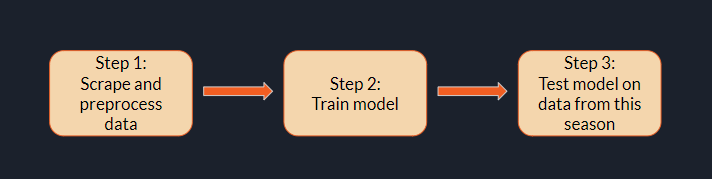

## **Step One: Data Scraping and Preprocessing**

In this segment, we will gather data from [Basketball-Reference](https://www.basketball-reference.com/) and [NBA API](https://github.com/swar/nba_api) and format it in a way that we can use to train our neural network. We'll collect various statistics from every player that received MVP votes dating back to the 1996-97 season. The first step is to install and import the various packages we'll use for this project.

In [ ]:
!pip install unidecode
!pip install nba_api
import pandas as pd
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from unidecode import unidecode

Next, we'll define some methods that allow us to find the players who are in consideration for MVP each season. Below is the method we'll use to find MVP candidates from previous seasons in which MVP voting has already occurred. We'll leverage [Pandas](https://pandas.pydata.org/docs/reference/index.html#api), a Python library for data manipulation and analysis. It offers data structures and operations for manipulating numerical tables and time series. In this project, we can use Pandas to structure and visualize our data.

In [ ]:
def top_mvp_cands(season):
  """
  top_mvp_cands() creates a table of the players who received MVP votes in a
  given season, in order.

  Parameters:
  season (int): the season to pull data from, e.g. 2022 for the 2021-22 NBA season.

  Returns:
  mvp_cands_df (Pandas dataframe): a table displaying the statistics of the
  players who received MVP votes that year, in order of voting place.
  """

  league_url = f"https://www.basketball-reference.com/awards/awards_{season}.html#mvp"
  time.sleep(6)  # Prevents rate limit errors
  table = pd.read_html(league_url)  # Reads in all award voting from a given season
  mvp_cands_df = table[0]  # Zero index corresponds to MVP award
  mvp_cands_df.columns = mvp_cands_df.columns.droplevel(0)  # Get rid of first row
  return mvp_cands_df

There's a lot happening in that function if you're new to Pandas! Feel free to experiment with the code to get a better sense of what's going on. For example, you can run "return table" to see what the entire table contains, you can play with the index of the table that we assign to our dataframe, and you can try dropping different levels from the columns. In a nutshell, this method reads in all the award voting information from a given season and saves it in a Pandas dataframe, selects the segment that corresponds to the MVP award, and drops the first row of the table that has some under-the-hood information we don't want to output.

Let's see what this method returns for the 2021-22 NBA season!

In [ ]:
top_mvp_cands(2022)

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,1,Nikola Jokić,26,DEN,65.0,875.0,1000,0.875,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296
1,2,Joel Embiid,27,PHI,26.0,706.0,1000,0.706,68,33.8,30.6,11.7,4.2,1.1,1.5,0.499,0.371,0.814,12.0,0.252
2,3,Giannis Antetokounmpo,27,MIL,9.0,595.0,1000,0.595,67,32.9,29.9,11.6,5.8,1.1,1.4,0.553,0.293,0.722,12.9,0.281
3,4,Devin Booker,25,PHO,0.0,216.0,1000,0.216,68,34.5,26.8,5.0,4.8,1.1,0.4,0.466,0.383,0.868,7.6,0.156
4,5,Luka Dončić,22,DAL,0.0,146.0,1000,0.146,65,35.4,28.4,9.1,8.7,1.2,0.6,0.457,0.353,0.744,7.6,0.159
5,6,Jayson Tatum,23,BOS,0.0,43.0,1000,0.043,76,35.9,26.9,8.0,4.4,1.0,0.6,0.453,0.353,0.853,9.6,0.169
6,7,Ja Morant,22,MEM,0.0,10.0,1000,0.010,57,33.1,27.4,5.7,6.7,1.2,0.4,0.493,0.344,0.761,6.7,0.171
7,8,Stephen Curry,33,GSW,0.0,4.0,1000,0.004,64,34.5,25.5,5.2,6.3,1.3,0.4,0.437,0.380,0.923,8.0,0.173
8,9,Chris Paul,36,PHO,0.0,2.0,1000,0.002,65,32.9,14.7,4.4,10.8,1.9,0.3,0.493,0.317,0.837,9.4,0.210
9,10T,DeMar DeRozan,32,CHI,0.0,1.0,1000,0.001,76,36.1,27.9,5.2,4.9,0.9,0.3,0.504,0.352,0.877,8.8,0.154


Whoa, that's pretty cool! But that's still more information than we need. Lucky for us, we can use Pandas to select precisely the columns that we're interested in. We want to track voting rank, player name, and vote shares:

In [ ]:
top_mvp_cands(2022)[["Rank","Player","Share"]].head(5)

,Rank,Player,Share
0,1,Nikola Jokić,0.875
1,2,Joel Embiid,0.706
2,3,Giannis Antetokounmpo,0.595
3,4,Devin Booker,0.216
4,5,Luka Dončić,0.146


We were able to filter out the columns that we didn't need! We only selected the columns ["Rank", "Player", "Share"] from the original dataframe. Furthermore, we used the .head() method to grab the first five rows, corresponding to the top five players in MVP voting.

Now that we can obtain the top five MVP candidates, we want to collect their statistics from NBA API and structure them in a way that makes training our neural network easier. The statistics we will collect are the following:

*   Wins
*   Losses
*   Win percentage
*   Points per game
*   Rebounds per game
*   Assists per game
*   Steals per game
*   Blocks per game
*   Turnovers per game
*   Plus-minus

We chose these stats as they are thought to have some correlation to which player wins the MVP, and because they are easily available via NBA API. We'll use MVP vote rank as the true output labels to train our neural network and we'll use the other stats as input data. This means that we want our model to learn where a player will place in MVP voting given their stats. We're getting ahead of ourselves though! Back to getting the data we need.

In [ ]:
model_input = ['W', 'L', 'W_PCT', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PTS', 'PLUS_MINUS']
model_output = ['Rank']

In [ ]:
# Per game endpoint
from nba_api.stats.endpoints import leaguedashplayerstats  # https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashplayerstats.md

def get_player_stats(season,
                     season_type="Regular Season",
                     per_mode="PerGame",
                     starter="Starters",
                     stat_type="Base"):
  """
  get_player_stats() pulls player statistics from NBA API.

  Parameters:
  season (int): the season to pull data from.
  season_type (string): selects regular season stats.
  per_mode (string): denotes per-game stats.
  starter (string): only includes players who start.
  stat_type (string): denotes basic stats.

  Returns:
  player_stats_df (Pandas dataframe): a table displaying the players
  and their statistics
  """

  player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season,  # Get stats from NBA API
                                                              season_type_all_star=season_type,
                                                              per_mode_detailed=per_mode,
                                                              starter_bench_nullable=starter,
                                                              measure_type_detailed_defense=stat_type)

  player_stats_df = pd.concat(player_stats.get_data_frames())  # Convert to Pandas dataframe

  return player_stats_df

This method gives us the framework to pull player statistics from NBA API. We convert each player_stats object into a Pandas dataframe, which we then concatenate into a single dataframe that contains all the player statistics that we wish to collect. Now let's gather all the data we need to train our model!

In [ ]:
# Running this block of code takes 3 minutes due to Basketball-Reference's rate limiting
collection = pd.DataFrame()
for year in range(1997,2024):
  season = f"{year - 1}-{year % 100:02}"  # Reformat season (e.g. 2021-22)

  # Get top five MVP candidates
  mvp_cands = top_mvp_cands(year)
  mvp_cands = mvp_cands.head(5)
  mvp_cands["Player"] = mvp_cands["Player"].apply(unidecode)  # Clean up accent marks in player names

  # Get their stats
  stats = get_player_stats(season)

  # Select player names
  player_names = mvp_cands["Player"].values

  # Ensures index corresponds to player names
  mvp_cands = mvp_cands.set_index(player_names)

  # Ensures the stats we collect corresond to MVP candidates
  stats = stats[stats['PLAYER_NAME'].isin(player_names)].reset_index()

  # Again, ensures index corresponds to player names
  stats = stats.set_index(stats['PLAYER_NAME'].values)

  # Create new dataframe for player stats
  numerical_df = stats.iloc[:, 6:]  # Throw out non-numerical values
  numerical_df = pd.concat([mvp_cands[["Rank","Share"]], numerical_df], axis=1)  # Add MVP vote rank and MVP vote shares columns to dataframe

  # Add player stats to multi-season dataframe
  collection = pd.concat([collection, numerical_df])

# Save all the data to a .csv file
collection.to_csv('mvp_data.csv')

In this last block of code, we iterated over every season that we're collecting data from. For each season, we selected the top five MVP candidates using top_mvp_cands() and grabbed their stats using get_player_stats(). We then created a new dataframe called "numerical_df" where we compiled all numerical data that we'll feed to our neural network. We used the Pandas [.iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) method to index into our "stats" dataframe and add all numerical values to "numerical_df". Then, we added MVP vote rank and MVP vote shares data from our "mvp_cands" dataframe as well. Finally, we added "numerical_df" to a larger dataframe that contains statistics from every season.

While we will use MVP vote rank as the output label for our neural network, we also included the framework for using MVP vote shares instead. Our initial plan was to focus on vote shares but this approach led to some problems.

First of all, vote shares don't work in the most intuitive way. The votes are scored from first to fifth place on ballots, but shares are earned from each placement, meaning the total shares between players add up to more than 100%, where an individual score of 100% means the player earned all first place votes for MVP that season. Secondly, we found using vote shares to be less accurate than using ranking in terms of model output. The results are reasonable but a bit worse. If you want an extra challenge, you can try to alter our code to predict the MVP with vote shares instead of rank by changing the value in the model_output list to "Share".

For more information on vote shares you can look at the [Basketball-Reference](https://www.basketball-reference.com/awards/awards_2023.html) award voting page or the official [NBA voter ballots](https://pr.nba.com/voting-results-2022-23-nba-regular-season-awards/).

NOTE: If you want to save the .csv file to your Google Drive so you don't have to reload it each time, uncomment the following block of code!

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/mvp_data.csv'
# collection.to_csv(file_path)

At this point, let's load the dataset back in and preprocess it so we can prepare to train our neural network. We'll split the dataset into input data, called features, and output data, called labels. As mentioned previously, the input data will be the player stats and the labels will be the players' MVP voting ranks. Here are the steps we'll take to preprocess our data:

1. First, we'll standardize the data using scikit-learn's [StandardScaler() method](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Data standardization is a crucial step in any neural network pipeline, as it puts all the data on the same scale. If you are unfamiliar with this concept, imagine you have a bunch of temperature data in Celsius, Fahrenheit, and Kelvin. Normalizing this data would mean changing it all to be the same unit of measurement so you can interpret it better. If you're interested, the way you standardize data is by subtracting the mean of the data from an individual data point and dividing by the standard deviation of the data. This centers the distribution of the data around 0 with a standard deviation of 1. If the specifics don't make sense to you, don't worry! All you need to understand is the temperature example.

2. Next, we'll convert our normalized data to [PyTorch tensors](https://pytorch.org/docs/stable/tensors.html), which is a data structure specifically designed for deep learning (neural network) tasks in PyTorch. A tensor is analogous to a matrix. You can think of it as a container for numerical data that we can manipulate very efficiently.

3. Then, we'll randomly split our data into training data and validation data using our own train_valid_split() method. We need training data to train the model, and validation data to evaluate the model once it's been trained. We'll use an 80/20 split, which is quite common.

4. Finally, we'll use PyTorch's [DataLoader() method](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to load our data efficiently, breaking it up into batches that we feed to the model little-by-little. While training a model, we want to pass data in batches and reshuffle the data after every training period to reduce model overfitting. You can think of overfitting as a neural network memorizing the data it sees and being unable to make predictions on new data. We want our neural network to learn underlying patterns in the data that it can generalize to data it hasn't seen before. We don't want it to hyperfocus on specific manifestations of those patterns. Think about studying for a test. Is the best strategy for long-term learning to memorize the material or learn the underlying concepts?

In [ ]:
def train_valid_split(X, y, train_split=0.8):
  """
  train_valid_split() splits up PyTorch tensors into training
  and testing subtensors to prepare for learning.

  Parameters:
  X (PyTorch tensor): input data.
  y (string): output data.
  train_split (float): the desired percentage of training data.

  Returns:
  Xtrain (PyTorch tensor): input data for training.
  ytrain (PyTorch tensor): output data for training.
  Xvalid (PyTorch tensor): input data for validation.
  yvalid (PyTorch tensor): output data for validation.
  """

  indices = torch.randperm(len(X))  # Randomly permute the indices of the input data

  split_index = int(train_split * len(X))  # Create split index

  # Split data!
  train_indices = indices[:split_index]
  Xtrain, ytrain = X[train_indices], y[train_indices]

  valid_indices = indices[split_index:]
  Xvalid, yvalid = X[valid_indices], y[valid_indices]

  return Xtrain, ytrain, Xvalid, yvalid

In [ ]:
# Load the dataset
df = pd.read_csv("mvp_data.csv")

# Split data into features and labels
X = df[model_input].values
y = df[model_output].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert arrays to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split dataset into train and test sets
X_train, y_train, X_valid, y_valid = train_valid_split(X_tensor, y_tensor)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


Let's see what our data looks like! We want our input data to be structured as an N x d matrix, where N is the number of candidates and d is the number of parameters, or the number of statistics per player, that we are training the model with. Since we are examining the top five MVP vote-getters from 27 seasons, N will be equal to 135. Since we are tracking 10 stats from each player, d will be equal to 10. Furthermore, we want our output data to be an N x 1 vector of the true labels from the dataset, which indicate where each player finished in MVP voting. This vector will be used to measure how well the model is learning and how accurate its predictions are.

Since we are employing an 80/20 split for our data, we should expect the shape of X_train to be 108 x 10, y_train to be 108 x 1, X_valid to be 27 x 10, and y_valid to be 27 x 1. Let's check out what's in each object and see if our predictions about their format are correct:

In [ ]:
X_train

tensor([[-6.8570e-01,  1.0805e+00, -1.1014e+00,  ...,  1.7886e+00,
          5.3875e-01, -9.3167e-01],
        [-6.8570e-01,  1.8507e+00, -1.5637e+00,  ..., -7.2068e-01,
          2.2026e+00, -8.8915e-01],
        [ 1.2328e+00, -1.2300e+00,  1.4350e+00,  ..., -1.5039e-01,
          2.4245e-01,  1.4495e+00],
        ...,
        [-2.2445e+00, -1.3840e+00,  9.8105e-02,  ...,  3.2713e+00,
         -1.2847e+00,  5.5654e-01],
        [ 5.1339e-01,  3.1035e-01, -1.8510e-03,  ..., -1.0628e+00,
         -1.0567e+00, -3.8741e-02],
        [ 5.1339e-01,  6.1841e-01, -2.1426e-01,  ..., -1.5039e-01,
         -5.3858e-02, -8.1261e-02]])

In [ ]:
y_train

tensor([[3.],
        [4.],
        [1.],
        [4.],
        [2.],
        [3.],
        [4.],
        [1.],
        [4.],
        [2.],
        [4.],
        [4.],
        [4.],
        [2.],
        [4.],
        [4.],
        [1.],
        [5.],
        [3.],
        [1.],
        [2.],
        [2.],
        [5.],
        [3.],
        [2.],
        [3.],
        [3.],
        [4.],
        [3.],
        [1.],
        [2.],
        [3.],
        [1.],
        [1.],
        [5.],
        [5.],
        [1.],
        [5.],
        [5.],
        [1.],
        [1.],
        [5.],
        [1.],
        [3.],
        [1.],
        [4.],
        [4.],
        [3.],
        [1.],
        [3.],
        [3.],
        [5.],
        [4.],
        [5.],
        [3.],
        [2.],
        [2.],
        [5.],
        [2.],
        [3.],
        [5.],
        [3.],
        [4.],
        [5.],
        [5.],
        [2.],
        [5.],
        [5.],
        [3.],
        [3.],
        [4.],
      

In [ ]:
X_train.shape

torch.Size([108, 10])

In [ ]:
y_train.shape

torch.Size([108, 1])

In [ ]:
X_valid

tensor([[ 3.9348e-01,  6.1841e-01, -2.6424e-01, -1.9248e-02,  2.1155e+00,
          3.5750e+00,  2.1398e-01, -6.0662e-01,  7.6668e-01, -3.7890e-01],
        [ 8.7311e-01,  1.5631e-01,  2.3554e-01,  1.4938e+00, -7.6075e-01,
          9.0846e-02, -1.3798e+00,  1.6745e+00, -5.3858e-02,  3.0142e-01],
        [ 3.3752e-02, -1.6921e+00,  1.5225e+00,  1.7899e+00, -3.2100e-02,
          7.8767e-01, -7.8215e-01, -3.6329e-02,  8.5785e-01,  2.0022e+00],
        [ 8.7311e-01, -1.5175e-01,  4.6044e-01,  8.0307e-01, -8.7580e-01,
         -4.6662e-01, -1.1806e+00,  1.5605e+00, -1.3075e+00,  1.4070e+00],
        [ 9.9302e-01, -9.2191e-01,  1.0977e+00, -1.5323e+00,  2.2689e+00,
          9.2704e-01, -1.1806e+00, -1.0628e+00, -1.6266e+00,  8.1167e-01],
        [ 1.5366e-01,  1.0805e+00, -6.7655e-01,  1.9872e+00, -1.6811e+00,
          9.0846e-02, -9.8137e-01,  1.2183e+00, -1.1479e+00, -8.1261e-02],
        [ 8.7311e-01,  1.5631e-01,  2.3554e-01,  1.3294e+00, -1.0292e+00,
         -1.8789e-01, -9.8137e-0

In [ ]:
y_valid

tensor([[2.],
        [1.],
        [1.],
        [4.],
        [2.],
        [5.],
        [2.],
        [1.],
        [3.],
        [5.],
        [2.],
        [3.],
        [3.],
        [2.],
        [1.],
        [4.],
        [2.],
        [5.],
        [2.],
        [4.],
        [1.],
        [2.],
        [5.],
        [2.],
        [1.],
        [2.],
        [1.]])

In [ ]:
X_valid.shape

torch.Size([27, 10])

In [ ]:
y_valid.shape

torch.Size([27, 1])

Woohoo! We were right! Remember, we standardized the input data so the contents of X_train and X_valid will appear to be random numbers, not data that corresponds to the statistics we scraped.

## **Step Two: Building the Model**

It's finally time to build the model! We are going to build a linear regression-based neural network. Here is the function that lies at the heart of this model, which you might be familiar with:

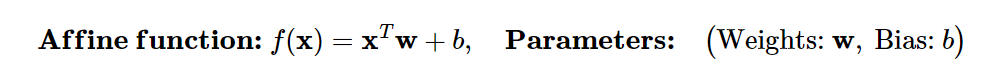

Our neural network is going to take our input data and learn how to draw a line of best fit through it, which is the line that is as close as possible to every single data point. Here's how we can visualize this:

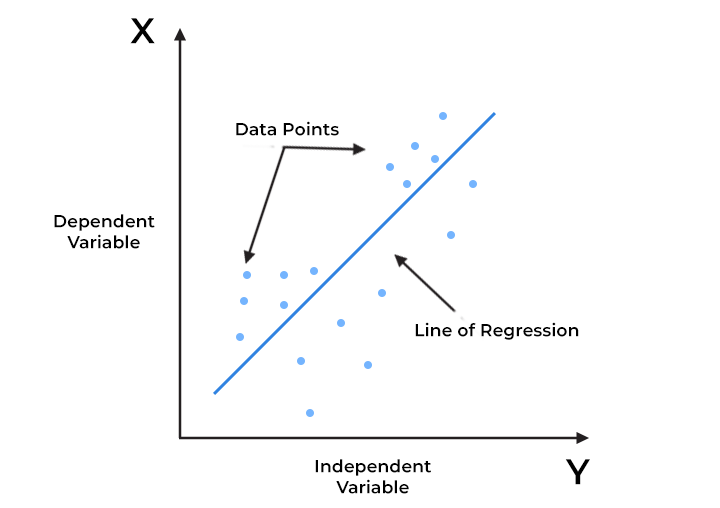

To build our neural network, we'll create a subclass of PyTorch's neural network module. [Inheritance](https://www.geeksforgeeks.org/inheritance-in-python/) allows us to define a class that inherits all the methods and properties from another class. In the class MVPWinner, we define a specific neural network architecture with four layers. Here is the flow of our model:

Our first layer, or input layer, has 10 nodes that correspond to the 10 different statistics that we feed the model per player. This layer is the gateway to our network. Our next layer is the first hidden layer, or intermediary layer in the model, which has 128 nodes. Each node in this layer takes these 10 inputs and applies a linear function, followed by a [ReLU activation function](https://www.kaggle.com/code/dansbecker/rectified-linear-units-relu-in-deep-learning), which returns 0 if it receives a negative input and returns the positive value it receives otherwise. This activation function is crucial because it allows the model to learn non-linear relationships in the data. After this, we have another hidden layer with 64 nodes, which takes the 128 outputs from the previous layer and applies the same procedure as before, resulting in 64 outputs. Finally, we have our output layer, which takes the results of the last hidden layer and uses a linear function to map its 64 inputs to one output. This output is the predicted rank of where the player will finish in MVP voting.

In a nutshell, our model takes the input data and passes it through these four layers, where each layer has nodes that apply an operation to the data it receives. Each layer is full-connected, meaning every node from a previous layer is connected to every node in the next layer. Thus, each neuron in a layer receives input data from all the neurons in the preceding layer.

Here's a quick visualization of a similar network, which takes four inputs, passes them to two hidden layers with three nodes each, and produces a single output:
<br>
<br>
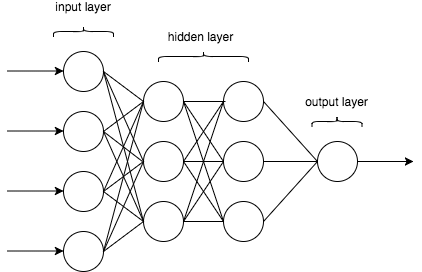

The way the model learns is by finding the optimal weights for each node in the network. Each node multiplies the input it receives by its weights to produce an output, which is passed forward through the network. To start off, we initialize the weights using [Xavier initialization](https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/#h_24242636975541686829817569), which is a common method in machine learning that randomly draws each weight from a normal distribution.

If you want to experiment with the network, you can change the number of nodes in the hidden layers, which are currently set to 128 and 64. You just need to make sure that the first layer has 10 inputs and the last layer has 1 output to match the structure of our data. Take a look at our MVPWinner class below!

In [ ]:
class MVPWinner(nn.Module):
  def __init__(self, in_dims, out_dims):
    """
    init() initializes our neural network, inheriting
    methods from the PyTorch nn.Module class.

    Parameters:
    self (MVPWinner): the model.
    in_dims (int): the input dimensions of the training data (in our case, 10).
    out_dims (int): the output dimensions of the model (in our case, 1).
    """

    super(MVPWinner, self).__init__()
    self.in_dims = in_dims
    self.out_dims = out_dims

    # Construct fully-connected network w/ two hidden layers
    self.fc = nn.Sequential(
        nn.Linear(self.in_dims, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, self.out_dims)
    )

    self.initialize_weights()

  def initialize_weights(self):
    """
    initialize_weights() initializes the weights of our
    model using Xavier initialization.

    Parameters:
    self (MVPWinner): the model.
    """

    # Iterate over modules of network
    for m in self.modules():
      # Apply Xavier initialization to linear layers
      if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

  def forward(self, X):
    """
    forward() passes input data through our neural netowrk, outputting
    a prediction. We invoke this method internally when training our
    model.

    Parameters:
    self (MVPWinner): the model.

    Returns:
    A tensor of output values that represent where the model
    predicts each player will place in MVP voting.
    """

    return self.fc(X)


  def predict_mvp(self, X):
    """
    predict_mvp() passes input data through our neural network,
    outputting a prediction. We invoke this method after we've
    trained our model and the weights have been optimized.

    Parameters:
    self (MVPWinner): the model.
    X (PyTorch tensor): the input data to feed the model.

    Returns:
    outputs (PyTorch tensor): the values representing where the
    model predicts each player will place in MVP voting.
    """

    with torch.no_grad():  # Disable gradient computation for prediction
      outputs = self.fc(X)  # Pass input data through model
    return outputs

It's going to be helpful to have a method that allows us to see how well our model is learning as we train it. Let's define a function using Matplotlib, a Python library for data visualization.

In [ ]:
def plot_loss(train_loss_history, valid_loss_history):
  """
  plot_loss() creates a graph of the training and validation
  loss of our model over time.

  Parameters:
  train_loss_history (list of floats): the training loss values of the model.
  valid_loss_history (list of floats): the validation loss values of the model.

  Returns:
  A plot displaying the training and validation loss.
  """

  f, ax = plt.subplots(figsize=(15, 4))  # Create a 15 x 4 inch plot
  ax.plot(train_loss_history, label='Training Loss')
  ax.plot(valid_loss_history, label='Validation Loss')
  ax.set_title('Loss Over Training Epochs')
  ax.legend()
  plt.show()

At this point, we're ready to train our model! First, we pick a loss function, which in this case we chose to be [mean squared error](https://statisticsbyjim.com/regression/mean-squared-error-mse/). This loss function returns the average distance between our input data and the line of best fit that our model draws, and squares it so the value is positive. The loss function effectively tells us how far away the model predictions are from the actual data points.

During each iteration (commonly referred to as an "epoch") of training, we have our model make predictions based off of the input data and then we calculate our loss, which compares the predictions to the actual output values. Next, we use gradient descent to minimize this loss value to ensure the best predictions possible. The gradient of any function points towards its minimum, so during each epoch we calculate the gradient, or the individual derivatives, of the output of the loss function with respect to each weight of our network. We can subtract this gradient from the weights each time and essentially move the weights of the network down the function, closer to the minimum.

A great way to understand gradient descent intuitively is to imagine rolling a ball down a hill. The ball will settle in the lowest point at the bottom of the hill, which represents the optimal value of our network weights! Furthermore, the rate at which the ball rolls down the hill is called the learning rate. We want our learning rate to be very low, so we don't overshoot the minimum of our loss function.

The way we calculate the gradient is using [back propagation](https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd), which uses the chain rule to go backwards through the network and calculate the derivative of the loss value with respect to each weight.

If you're interested in further learning on the concepts of gradient descent and backpropogation, make sure to check out these amazing videos by 3Blue1Brown that will help you visualize and understand what is going on:

*   [Gradient descent](https://www.youtube.com/watch?v=IHZwWFHWa-w)
*   [Backpropogation](https://www.youtube.com/watch?v=Ilg3gGewQ5U)


In [ ]:
def train_model(model, train_loader, valid_loader, lr, epochs):
  """
  train_model() trains our neural network.

  Parameters:
  model (MVPWinner): the model.
  train_loader (PyTorch DataLoader): the training data for the model.
  valid_loader (PyTorch DataLoader): the validation data for the model.
  lr (float): the learning rate of the model.
  epochs (int): the number of iterations to train the model.

  Returns:
  train_losses (list of floats): the training loss values from each epoch.
  valid_losses (list of floats): the validation loss values from each epoch.
  """

  loss_func = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr)

  train_losses = []
  valid_losses = []

  # Training loop
  for epoch in range(epochs):

    for x, y in train_loader:
      # Generate prediction
      y_hat = model(x)

      # Calculate loss of prediction w/ respect to true output label
      loss = loss_func(y_hat, y)
      train_loss = loss.detach().item()

      # Perform one step of gradient descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs} Training loss: {train_loss:.2f}")

    # Validation loop
    model.eval()
    with torch.no_grad():
      for x, y in valid_loader:
        # Generate prediction
        y_hat = model(x)

        # Calculate loss of prediction w/ respect to true output label
        valid_loss = loss_func(y_hat, y).detach().item()

      valid_losses.append(valid_loss)
      print(f"Valid loss: {valid_loss:.2f}")

  return train_losses, valid_losses

Once our train_model() is defined, we can actually train our model. First, we create an instance of our model with the correct input and output dimensions. Then, we train our model using the method we just created and visualize how well the model learns using our plot_loss() method.

Again, feel free to explore with some of the parameters here, in addition to the dimensions of the hidden layers of the model. We set the learning rate to be 0.001 and the number of epochs to be 50, but there's no exact science behind it. Experiment to find the combination that results in the lowest validation loss! While the training loss measures how well the model fits the training data, the validation loss provides an estimate of how well the model will perform on new, unseen data. Monitoring the validation loss will help us gauge the model's ability to generalize to data it hasn't seen before.

NOTE: A learning rate will commonly be between 0.0 and 1.0.

Epoch 1/50 Training loss: 12.38
Valid loss: 7.88
Epoch 2/50 Training loss: 10.13
Valid loss: 6.36
Epoch 3/50 Training loss: 5.84
Valid loss: 5.11
Epoch 4/50 Training loss: 5.84
Valid loss: 4.09
Epoch 5/50 Training loss: 5.69
Valid loss: 3.30
Epoch 6/50 Training loss: 6.16
Valid loss: 2.74
Epoch 7/50 Training loss: 3.39
Valid loss: 2.44
Epoch 8/50 Training loss: 1.88
Valid loss: 2.36
Epoch 9/50 Training loss: 3.86
Valid loss: 2.42
Epoch 10/50 Training loss: 1.44
Valid loss: 2.49
Epoch 11/50 Training loss: 2.53
Valid loss: 2.49
Epoch 12/50 Training loss: 2.35
Valid loss: 2.40
Epoch 13/50 Training loss: 1.90
Valid loss: 2.29
Epoch 14/50 Training loss: 1.75
Valid loss: 2.17
Epoch 15/50 Training loss: 1.11
Valid loss: 2.10
Epoch 16/50 Training loss: 2.76
Valid loss: 2.05
Epoch 17/50 Training loss: 1.31
Valid loss: 2.02
Epoch 18/50 Training loss: 1.66
Valid loss: 2.00
Epoch 19/50 Training loss: 1.89
Valid loss: 1.99
Epoch 20/50 Training loss: 1.42
Valid loss: 1.98
Epoch 21/50 Training loss: 

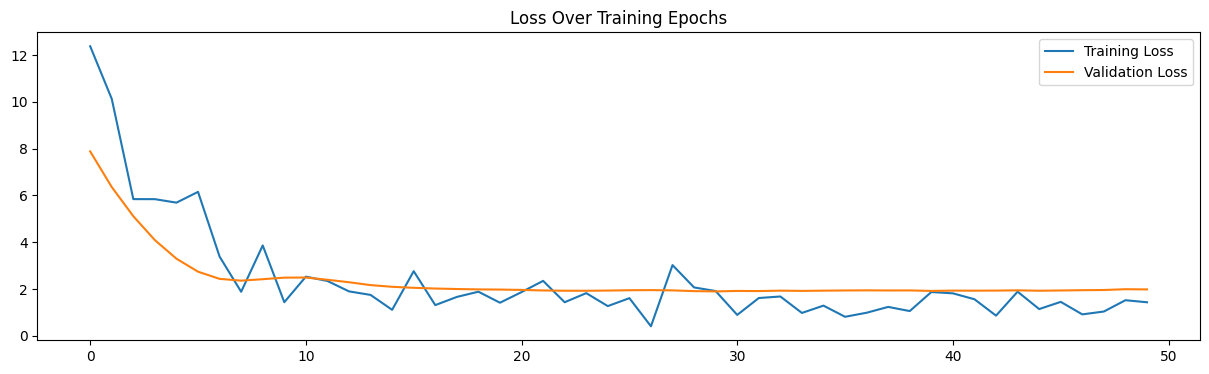

In [ ]:
model = MVPWinner(10, 1)
train_losses, valid_losses = train_model(model, train_loader, valid_loader, 0.001, 50)
plot_loss(train_losses, valid_losses)

## **Step Three: Generating Predictions**

Now that we've trained the model to our liking, let's give it a litmus test and see how well it does on data from this season. Since MVP voting hasn't been released yet for this year, we'll use NBA fantasy points as a heuristic for MVP candidates; the players with the most fantasy points are often the best players in the league who are in the running for MVP. Let's do this in a few lines of code with Pandas.

In [ ]:
curr_candidates = []

# Grab top 10 players in fantasy points and their stats for 2023-24 season
year = 2024
season = f"{year - 1}-{year % 100}"  # Reformat season
sorted_stats = get_player_stats(season).sort_values(by = "NBA_FANTASY_PTS_RANK")
sorted_stats = sorted_stats[sorted_stats['GP'] > 64]  # Players must play 65 games to be elegible to win MVP
sorted_stats = sorted_stats[['PLAYER_NAME'] + model_input]  # Add back player name to list of stats
curr_candidates = sorted_stats.head(10).values.tolist()

Let's see what this returns!

In [ ]:
curr_candidates

[['Luka Doncic', 46, 24, 0.657, 9.2, 9.8, 4.0, 1.4, 0.5, 33.9, 4.6],
 ['Nikola Jokic', 55, 24, 0.696, 12.4, 9.0, 3.0, 1.4, 0.9, 26.4, 8.6],
 ['Giannis Antetokounmpo', 45, 28, 0.616, 11.5, 6.5, 3.4, 1.2, 1.1, 30.4, 4.6],
 ['Anthony Davis', 45, 31, 0.592, 12.6, 3.5, 2.1, 1.2, 2.3, 24.7, 2.0],
 ['Shai Gilgeous-Alexander',
  55,
  20,
  0.733,
  5.5,
  6.2,
  2.2,
  2.0,
  0.9,
  30.1,
  8.2],
 ['Victor Wembanyama', 19, 52, 0.268, 10.6, 3.9, 3.7, 1.2, 3.6, 21.4, -2.0],
 ['Domantas Sabonis', 46, 36, 0.561, 13.7, 8.2, 3.3, 0.9, 0.6, 19.4, 0.8],
 ['LeBron James', 41, 30, 0.577, 7.3, 8.3, 3.5, 1.3, 0.5, 25.7, 3.1],
 ['Jayson Tatum', 57, 17, 0.77, 8.1, 4.9, 2.5, 1.0, 0.6, 26.9, 8.2],
 ['Kevin Durant', 44, 31, 0.587, 6.6, 5.0, 3.3, 0.9, 1.2, 27.1, 3.9]]

At this point, we can see where our model predicts these players will finish in this season's MVP voting.

In [ ]:
final_results = []
for i in curr_candidates:
  new_data = torch.tensor([i[1:]], dtype=torch.float32)  # We don't include player names as input data
  new_data_scaled = torch.tensor(scaler.transform(new_data), dtype=torch.float32)  # Standardize data
  outputs = model.predict_mvp(new_data_scaled)  # Predict MVP voting placement
  final_results.append([i[0], outputs.item()])  # Add player name and predicted rank to final_results

final_results.sort(key=lambda x: x[1])  # Sort list in ascending order of predicted rank

# Print out the predicted top five players in MVP voting
for i in range(5):
  print(f"{i+1}. {final_results[i][0]}")

1. Nikola Jokic
2. Shai Gilgeous-Alexander
3. Jayson Tatum
4. Giannis Antetokounmpo
5. Luka Doncic


This is awesome! We built a neural network to predict the NBA MVP! If our model does well, it should predict that Nikola Jokic wins the award, with Shai-Gilgeous Alexander coming in second place and some permutation of Luka Doncic, Giannis Antetokounmpo, and Jayson Tatum in third through fifth place. Compare the model output to what sports writers at NBA.com [predict](https://www.nba.com/news/kia-mvp-ladder-april-12-2024-edition)!

Congratulations on completing the tutorial! You've learned a lot in a short amount of time, and hopefully you're eager to learn more. Given that we are able to accurately predict MVP winners with a neural network, it seems that there is some logic and objectivity behind MVP voting. We certainly know that the statistics we fed the model are correlated to which player wins MVP. However, the MVP race this season is fairly straightforward, with the consensus being that Nikola Jokic will win and Shai Gilgeous-Alexander will finish second. How would the model perform in a year where the MVP winner was an outlier and wasn't statistically the most dominant player in the NBA? For example, it would be interesting to see who the model predicts should have won last season (2022-23) between Joel Embiid and Nikola Jokic, given how contentious that MVP race was and how much it was driven by media narrative, which our model doesn't take into account. If you're interested, you should go find out!



<div style="display: flex; justify-content: center;">
    <img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExOTVjb3VqMjI3YTExZWdhNnQwb2hwaDdwNnM2eDc3dGtlemVheWE1aCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/KiWPIal80StPkNW39e/giphy.gif" style="max-width: 100%; max-height: 100%; margin: auto;">
</div>

## **Image Credits**

*   [GIF 1](https://giphy.com/gifs/nba-basketball-mvp-nikola-jokic-r9t4G4O5zjw4BqpFAX)
*   [Linear regression graph](https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-linear-regression/)
*   [Neural network outline](https://analyticsindiamag.com/topics/what-is-dense-layer-in-neural-network/)
*   [GIF 2](https://giphy.com/gifs/hornets-charlotte-charlottehornets-markwilliams-KiWPIal80StPkNW39e)

